In [156]:
import cv2
from skimage import io
from skimage import img_as_float
from  matplotlib import pyplot as plt
import numpy as np

In [157]:
my_image=io.imread('original_images/7.png')

In [158]:
print(type(my_image)) # image is a numpy array
print(my_image.dtype) # image is of dtype
print(my_image.shape) # image is of shape

<class 'numpy.ndarray'>
uint8
(1059, 1024, 3)


In [159]:
from simple_multi_unet_model import multi_unet_model #Uses softmax 

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [160]:
# Multiclass Semantic Segmentation on images
SIZE_X=128
SIZE_Y=128
n_classes=4
train_images=[]

In [161]:
for directory_path in glob.glob("original_images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

In [162]:
train_images[0].shape

(128, 128)

In [163]:
train_images[0].dtype

dtype('uint8')

In [164]:
len(train_images)

25

In [165]:
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("masked_images/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [166]:
train_masks[0].shape

(128, 128)

In [167]:
train_masks[0].dtype

dtype('uint8')

In [168]:
len(train_masks)

25

In [169]:
np.unique(train_masks)

array([  0,  38,  75, 113], dtype=uint8)

In [170]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/home/ankit/Desktop/ml/Tensorflow_ENV/tfenv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [171]:
n, h, w = train_masks.shape

In [172]:
n

25

In [173]:
h

128

In [174]:
w

128

In [175]:
train_masks_encoded_original_shape.shape

(25, 128, 128)

In [176]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

In [177]:
train_images.shape

(25, 128, 128, 1)

In [178]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [179]:
train_masks_input.shape

(25, 128, 128, 1)

In [180]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3]


In [181]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [182]:
y_train_cat.shape

(17, 128, 128, 4)

In [183]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [184]:
y_test_cat.shape

(3, 128, 128, 4)

In [185]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(train_masks_reshaped_encoded),y=train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

Class weights are...: [ 0.41695169  0.73766181 14.24794768  5.68762497]


In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=1000, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


model.save('test.hdf5')
model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 128, 128, 16  160         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_72 (Dropout)           (None, 128, 128, 16  0           ['conv2d_152[0][0]']             
                                )                                                           

 dropout_79 (Dropout)           (None, 64, 64, 32)   0           ['conv2d_166[0][0]']             
                                                                                                  
 conv2d_167 (Conv2D)            (None, 64, 64, 32)   9248        ['dropout_79[0][0]']             
                                                                                                  
 conv2d_transpose_35 (Conv2DTra  (None, 128, 128, 16  2064       ['conv2d_167[0][0]']             
 nspose)                        )                                                                 
                                                                                                  
 concatenate_35 (Concatenate)   (None, 128, 128, 32  0           ['conv2d_transpose_35[0][0]',    
                                )                                 'conv2d_153[0][0]']             
                                                                                                  
 conv2d_16

Epoch 42/1000
2/2 [==============================] - 1s 118ms/step - loss: 0.6977 - accuracy: 0.7369 - val_loss: 0.9005 - val_accuracy: 0.6827
Epoch 43/1000
2/2 [==============================] - 1s 137ms/step - loss: 0.6955 - accuracy: 0.7578 - val_loss: 0.6825 - val_accuracy: 0.7574
Epoch 44/1000
2/2 [==============================] - 1s 203ms/step - loss: 0.6134 - accuracy: 0.7923 - val_loss: 0.7429 - val_accuracy: 0.7280
Epoch 45/1000
2/2 [==============================] - 1s 156ms/step - loss: 0.6143 - accuracy: 0.7914 - val_loss: 0.6518 - val_accuracy: 0.7618
Epoch 46/1000
2/2 [==============================] - 1s 163ms/step - loss: 0.5694 - accuracy: 0.8053 - val_loss: 0.6656 - val_accuracy: 0.7682
Epoch 47/1000
2/2 [==============================] - 1s 237ms/step - loss: 0.5594 - accuracy: 0.8174 - val_loss: 0.8663 - val_accuracy: 0.7221
Epoch 48/1000
2/2 [==============================] - 1s 218ms/step - loss: 0.6364 - accuracy: 0.7988 - val_loss: 0.5995 - val_accuracy: 0.8065

2/2 [==============================] - 1s 190ms/step - loss: 0.2771 - accuracy: 0.9004 - val_loss: 0.6430 - val_accuracy: 0.8600
Epoch 100/1000
2/2 [==============================] - 1s 247ms/step - loss: 0.2801 - accuracy: 0.9014 - val_loss: 0.7511 - val_accuracy: 0.8458
Epoch 101/1000
2/2 [==============================] - 1s 224ms/step - loss: 0.2682 - accuracy: 0.9063 - val_loss: 0.8293 - val_accuracy: 0.8375
Epoch 102/1000
2/2 [==============================] - 1s 154ms/step - loss: 0.2786 - accuracy: 0.9031 - val_loss: 0.6248 - val_accuracy: 0.8578
Epoch 103/1000
2/2 [==============================] - 1s 160ms/step - loss: 0.2623 - accuracy: 0.9053 - val_loss: 0.6558 - val_accuracy: 0.8461
Epoch 104/1000
2/2 [==============================] - 1s 218ms/step - loss: 0.2840 - accuracy: 0.8985 - val_loss: 0.5514 - val_accuracy: 0.8607
Epoch 105/1000
2/2 [==============================] - 1s 227ms/step - loss: 0.2738 - accuracy: 0.9022 - val_loss: 0.7394 - val_accuracy: 0.8342
Epoch 1

Epoch 156/1000
2/2 [==============================] - 1s 113ms/step - loss: 0.1396 - accuracy: 0.9469 - val_loss: 0.8924 - val_accuracy: 0.8378
Epoch 157/1000
2/2 [==============================] - 1s 133ms/step - loss: 0.1325 - accuracy: 0.9496 - val_loss: 0.9271 - val_accuracy: 0.8411
Epoch 158/1000
2/2 [==============================] - 1s 130ms/step - loss: 0.1315 - accuracy: 0.9495 - val_loss: 0.9254 - val_accuracy: 0.8350
Epoch 159/1000
2/2 [==============================] - 1s 178ms/step - loss: 0.1269 - accuracy: 0.9513 - val_loss: 0.9674 - val_accuracy: 0.8290
Epoch 160/1000
2/2 [==============================] - 1s 160ms/step - loss: 0.1324 - accuracy: 0.9496 - val_loss: 0.8679 - val_accuracy: 0.8417
Epoch 161/1000
2/2 [==============================] - 1s 129ms/step - loss: 0.1385 - accuracy: 0.9458 - val_loss: 1.0291 - val_accuracy: 0.8231
Epoch 162/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.1540 - accuracy: 0.9404 - val_loss: 0.8322 - val_accuracy:

Epoch 213/1000
2/2 [==============================] - 1s 127ms/step - loss: 0.0817 - accuracy: 0.9686 - val_loss: 1.0343 - val_accuracy: 0.8342
Epoch 214/1000
2/2 [==============================] - 1s 382ms/step - loss: 0.0808 - accuracy: 0.9685 - val_loss: 1.1322 - val_accuracy: 0.8334
Epoch 215/1000
2/2 [==============================] - 1s 275ms/step - loss: 0.0816 - accuracy: 0.9681 - val_loss: 1.1037 - val_accuracy: 0.8345
Epoch 216/1000
2/2 [==============================] - 1s 184ms/step - loss: 0.0803 - accuracy: 0.9690 - val_loss: 1.0321 - val_accuracy: 0.8366
Epoch 217/1000
2/2 [==============================] - 1s 179ms/step - loss: 0.0811 - accuracy: 0.9684 - val_loss: 1.1232 - val_accuracy: 0.8363
Epoch 218/1000
2/2 [==============================] - 1s 216ms/step - loss: 0.0840 - accuracy: 0.9677 - val_loss: 1.0063 - val_accuracy: 0.8410
Epoch 219/1000
2/2 [==============================] - 1s 144ms/step - loss: 0.0854 - accuracy: 0.9670 - val_loss: 1.0990 - val_accuracy:

Epoch 270/1000
2/2 [==============================] - 1s 119ms/step - loss: 0.0605 - accuracy: 0.9762 - val_loss: 1.3017 - val_accuracy: 0.8271
Epoch 271/1000
2/2 [==============================] - 1s 129ms/step - loss: 0.0631 - accuracy: 0.9751 - val_loss: 1.2108 - val_accuracy: 0.8308
Epoch 272/1000
2/2 [==============================] - 1s 174ms/step - loss: 0.0610 - accuracy: 0.9759 - val_loss: 1.2524 - val_accuracy: 0.8319
Epoch 273/1000
2/2 [==============================] - 1s 136ms/step - loss: 0.0567 - accuracy: 0.9780 - val_loss: 1.2813 - val_accuracy: 0.8314
Epoch 274/1000
2/2 [==============================] - 1s 167ms/step - loss: 0.0583 - accuracy: 0.9773 - val_loss: 1.2453 - val_accuracy: 0.8335
Epoch 275/1000
2/2 [==============================] - 1s 169ms/step - loss: 0.0584 - accuracy: 0.9768 - val_loss: 1.2955 - val_accuracy: 0.8315
Epoch 276/1000
2/2 [==============================] - 1s 139ms/step - loss: 0.0559 - accuracy: 0.9779 - val_loss: 1.2539 - val_accuracy:

Epoch 327/1000
2/2 [==============================] - 1s 149ms/step - loss: 0.0465 - accuracy: 0.9813 - val_loss: 1.3072 - val_accuracy: 0.8327
Epoch 328/1000
2/2 [==============================] - 1s 136ms/step - loss: 0.0487 - accuracy: 0.9807 - val_loss: 1.3661 - val_accuracy: 0.8316
Epoch 329/1000
2/2 [==============================] - 1s 152ms/step - loss: 0.0484 - accuracy: 0.9809 - val_loss: 1.3286 - val_accuracy: 0.8300
Epoch 330/1000
2/2 [==============================] - 1s 165ms/step - loss: 0.0467 - accuracy: 0.9816 - val_loss: 1.2969 - val_accuracy: 0.8344
Epoch 331/1000
2/2 [==============================] - 1s 119ms/step - loss: 0.0472 - accuracy: 0.9811 - val_loss: 1.3357 - val_accuracy: 0.8345
Epoch 332/1000
2/2 [==============================] - 1s 120ms/step - loss: 0.0453 - accuracy: 0.9821 - val_loss: 1.3350 - val_accuracy: 0.8327
Epoch 333/1000
2/2 [==============================] - 1s 154ms/step - loss: 0.0457 - accuracy: 0.9819 - val_loss: 1.2886 - val_accuracy:

Epoch 384/1000
2/2 [==============================] - 1s 128ms/step - loss: 0.0391 - accuracy: 0.9845 - val_loss: 1.5209 - val_accuracy: 0.8333
Epoch 385/1000
2/2 [==============================] - 1s 147ms/step - loss: 0.0393 - accuracy: 0.9841 - val_loss: 1.3620 - val_accuracy: 0.8370
Epoch 386/1000
2/2 [==============================] - 1s 136ms/step - loss: 0.0413 - accuracy: 0.9833 - val_loss: 1.4505 - val_accuracy: 0.8325
Epoch 387/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.0377 - accuracy: 0.9846 - val_loss: 1.5915 - val_accuracy: 0.8269
Epoch 388/1000
2/2 [==============================] - 1s 125ms/step - loss: 0.0423 - accuracy: 0.9831 - val_loss: 1.4220 - val_accuracy: 0.8306
Epoch 389/1000
2/2 [==============================] - 1s 119ms/step - loss: 0.0401 - accuracy: 0.9837 - val_loss: 1.4481 - val_accuracy: 0.8315
Epoch 390/1000
2/2 [==============================] - 1s 120ms/step - loss: 0.0387 - accuracy: 0.9844 - val_loss: 1.4801 - val_accuracy:

Epoch 441/1000
2/2 [==============================] - 1s 135ms/step - loss: 0.0335 - accuracy: 0.9864 - val_loss: 1.6122 - val_accuracy: 0.8319
Epoch 442/1000
2/2 [==============================] - 1s 136ms/step - loss: 0.0337 - accuracy: 0.9863 - val_loss: 1.6150 - val_accuracy: 0.8318
Epoch 443/1000
2/2 [==============================] - 1s 146ms/step - loss: 0.0338 - accuracy: 0.9863 - val_loss: 1.5787 - val_accuracy: 0.8299
Epoch 444/1000
2/2 [==============================] - 1s 139ms/step - loss: 0.0346 - accuracy: 0.9859 - val_loss: 1.6591 - val_accuracy: 0.8288
Epoch 445/1000
2/2 [==============================] - 1s 127ms/step - loss: 0.0338 - accuracy: 0.9863 - val_loss: 1.6909 - val_accuracy: 0.8293
Epoch 446/1000
2/2 [==============================] - 1s 124ms/step - loss: 0.0346 - accuracy: 0.9860 - val_loss: 1.5855 - val_accuracy: 0.8305
Epoch 447/1000
2/2 [==============================] - 1s 124ms/step - loss: 0.0353 - accuracy: 0.9856 - val_loss: 1.5621 - val_accuracy:

Epoch 498/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.0315 - accuracy: 0.9873 - val_loss: 1.6515 - val_accuracy: 0.8303
Epoch 499/1000
2/2 [==============================] - 1s 127ms/step - loss: 0.0309 - accuracy: 0.9873 - val_loss: 1.7212 - val_accuracy: 0.8296
Epoch 500/1000
2/2 [==============================] - 1s 120ms/step - loss: 0.0313 - accuracy: 0.9872 - val_loss: 1.7592 - val_accuracy: 0.8288
Epoch 501/1000
2/2 [==============================] - 1s 124ms/step - loss: 0.0317 - accuracy: 0.9872 - val_loss: 1.7215 - val_accuracy: 0.8292
Epoch 502/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.0313 - accuracy: 0.9870 - val_loss: 1.7868 - val_accuracy: 0.8290
Epoch 503/1000
2/2 [==============================] - 1s 121ms/step - loss: 0.0310 - accuracy: 0.9873 - val_loss: 1.6813 - val_accuracy: 0.8315
Epoch 504/1000
2/2 [==============================] - 1s 126ms/step - loss: 0.0310 - accuracy: 0.9874 - val_loss: 1.6753 - val_accuracy:

Epoch 555/1000
2/2 [==============================] - 1s 125ms/step - loss: 0.0290 - accuracy: 0.9881 - val_loss: 1.6855 - val_accuracy: 0.8336
Epoch 556/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.0312 - accuracy: 0.9873 - val_loss: 1.7378 - val_accuracy: 0.8305
Epoch 557/1000
2/2 [==============================] - 1s 121ms/step - loss: 0.0298 - accuracy: 0.9878 - val_loss: 1.7770 - val_accuracy: 0.8255
Epoch 558/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.0293 - accuracy: 0.9881 - val_loss: 1.7829 - val_accuracy: 0.8278
Epoch 559/1000
2/2 [==============================] - 1s 121ms/step - loss: 0.0291 - accuracy: 0.9882 - val_loss: 1.7489 - val_accuracy: 0.8287
Epoch 560/1000
2/2 [==============================] - 1s 124ms/step - loss: 0.0291 - accuracy: 0.9882 - val_loss: 1.7417 - val_accuracy: 0.8273
Epoch 561/1000
2/2 [==============================] - 1s 120ms/step - loss: 0.0282 - accuracy: 0.9885 - val_loss: 1.6368 - val_accuracy:

Epoch 612/1000
2/2 [==============================] - 1s 121ms/step - loss: 0.0257 - accuracy: 0.9894 - val_loss: 1.7148 - val_accuracy: 0.8333
Epoch 613/1000
2/2 [==============================] - 1s 125ms/step - loss: 0.0282 - accuracy: 0.9884 - val_loss: 1.8316 - val_accuracy: 0.8295
Epoch 614/1000
2/2 [==============================] - 1s 138ms/step - loss: 0.0262 - accuracy: 0.9891 - val_loss: 1.8608 - val_accuracy: 0.8306
Epoch 615/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.0251 - accuracy: 0.9896 - val_loss: 1.8174 - val_accuracy: 0.8316
Epoch 616/1000
2/2 [==============================] - 1s 121ms/step - loss: 0.0263 - accuracy: 0.9892 - val_loss: 1.8148 - val_accuracy: 0.8298
Epoch 617/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.0256 - accuracy: 0.9894 - val_loss: 1.7988 - val_accuracy: 0.8307
Epoch 618/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.0252 - accuracy: 0.9896 - val_loss: 1.8727 - val_accuracy:

Epoch 669/1000
2/2 [==============================] - 1s 155ms/step - loss: 0.0235 - accuracy: 0.9904 - val_loss: 1.8493 - val_accuracy: 0.8315
Epoch 670/1000
2/2 [==============================] - 1s 121ms/step - loss: 0.0233 - accuracy: 0.9903 - val_loss: 1.9309 - val_accuracy: 0.8302
Epoch 671/1000
2/2 [==============================] - 1s 123ms/step - loss: 0.0237 - accuracy: 0.9903 - val_loss: 1.8630 - val_accuracy: 0.8313
Epoch 672/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.0235 - accuracy: 0.9904 - val_loss: 1.8272 - val_accuracy: 0.8323
Epoch 673/1000
2/2 [==============================] - 1s 122ms/step - loss: 0.0226 - accuracy: 0.9907 - val_loss: 1.9031 - val_accuracy: 0.8314
Epoch 674/1000
2/2 [==============================] - 1s 124ms/step - loss: 0.0243 - accuracy: 0.9903 - val_loss: 1.8287 - val_accuracy: 0.8332
Epoch 675/1000
2/2 [==============================] - 1s 130ms/step - loss: 0.0230 - accuracy: 0.9903 - val_loss: 1.7925 - val_accuracy:

Epoch 726/1000
2/2 [==============================] - 1s 124ms/step - loss: 0.0227 - accuracy: 0.9907 - val_loss: 1.8734 - val_accuracy: 0.8318
Epoch 727/1000
2/2 [==============================] - 1s 176ms/step - loss: 0.0234 - accuracy: 0.9906 - val_loss: 2.0690 - val_accuracy: 0.8296
Epoch 728/1000
2/2 [==============================] - 1s 138ms/step - loss: 0.0240 - accuracy: 0.9901 - val_loss: 1.9787 - val_accuracy: 0.8285
Epoch 729/1000
2/2 [==============================] - 1s 140ms/step - loss: 0.0219 - accuracy: 0.9911 - val_loss: 2.0514 - val_accuracy: 0.8254
Epoch 730/1000
2/2 [==============================] - 1s 176ms/step - loss: 0.0228 - accuracy: 0.9906 - val_loss: 2.0889 - val_accuracy: 0.8254
Epoch 731/1000
2/2 [==============================] - 1s 173ms/step - loss: 0.0226 - accuracy: 0.9910 - val_loss: 2.0381 - val_accuracy: 0.8290
Epoch 732/1000
2/2 [==============================] - 1s 127ms/step - loss: 0.0219 - accuracy: 0.9910 - val_loss: 2.0349 - val_accuracy:

Epoch 783/1000
2/2 [==============================] - 1s 152ms/step - loss: 0.0202 - accuracy: 0.9916 - val_loss: 2.1207 - val_accuracy: 0.8320
Epoch 784/1000
2/2 [==============================] - 1s 141ms/step - loss: 0.0197 - accuracy: 0.9920 - val_loss: 2.1566 - val_accuracy: 0.8316
Epoch 785/1000
2/2 [==============================] - 1s 143ms/step - loss: 0.0203 - accuracy: 0.9917 - val_loss: 2.0422 - val_accuracy: 0.8317
Epoch 786/1000
2/2 [==============================] - 1s 190ms/step - loss: 0.0203 - accuracy: 0.9915 - val_loss: 2.0891 - val_accuracy: 0.8312
Epoch 787/1000
2/2 [==============================] - 1s 128ms/step - loss: 0.0204 - accuracy: 0.9917 - val_loss: 2.1233 - val_accuracy: 0.8301
Epoch 788/1000
2/2 [==============================] - 1s 121ms/step - loss: 0.0197 - accuracy: 0.9920 - val_loss: 2.0834 - val_accuracy: 0.8298
Epoch 789/1000
2/2 [==============================] - 1s 136ms/step - loss: 0.0193 - accuracy: 0.9920 - val_loss: 2.1240 - val_accuracy:

Epoch 840/1000
2/2 [==============================] - 1s 157ms/step - loss: 0.0187 - accuracy: 0.9924 - val_loss: 2.1119 - val_accuracy: 0.8323
Epoch 841/1000
2/2 [==============================] - 1s 154ms/step - loss: 0.0190 - accuracy: 0.9922 - val_loss: 2.2006 - val_accuracy: 0.8312
Epoch 842/1000
2/2 [==============================] - 1s 131ms/step - loss: 0.0181 - accuracy: 0.9926 - val_loss: 2.1082 - val_accuracy: 0.8325
Epoch 843/1000
2/2 [==============================] - 1s 135ms/step - loss: 0.0173 - accuracy: 0.9929 - val_loss: 2.0292 - val_accuracy: 0.8336
Epoch 844/1000
2/2 [==============================] - 1s 134ms/step - loss: 0.0193 - accuracy: 0.9920 - val_loss: 2.1026 - val_accuracy: 0.8302
Epoch 845/1000
2/2 [==============================] - 1s 128ms/step - loss: 0.0186 - accuracy: 0.9926 - val_loss: 2.1493 - val_accuracy: 0.8288
Epoch 846/1000
2/2 [==============================] - 1s 136ms/step - loss: 0.0175 - accuracy: 0.9929 - val_loss: 2.1566 - val_accuracy:

In [ ]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
##################################
#model = get_model()
#model.load_weights('sandstone_50_epochs_catXentropy_acc.hdf5')  
model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)


In [ ]:
##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


In [ ]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

In [ ]:
plt.imshow(train_images[0, :,:,0], cmap='gray')

In [ ]:
plt.imshow(train_masks[0], cmap='gray')

In [ ]:
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

In [ ]:
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

In [ ]:
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [153]:
#Predict on large image

#Apply a trained model on large image

from patchify import patchify, unpatchify

large_image = cv2.imread('original_images/2.png', 0)
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap

In [154]:
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')

0 0
1/1 [==============================] - 0s 23ms/step
0 1
1/1 [==============================] - 0s 22ms/step
0 2
1/1 [==============================] - 0s 30ms/step
0 3
1/1 [==============================] - 0s 23ms/step
0 4
1/1 [==============================] - 0s 23ms/step
0 5
1/1 [==============================] - 0s 23ms/step
0 6
1/1 [==============================] - 0s 23ms/step
0 7
1/1 [==============================] - 0s 25ms/step
1 0
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 2
1/1 [==============================] - 0s 23ms/step
1 3
1/1 [==============================] - 0s 28ms/step
1 4
1/1 [==============================] - 0s 27ms/step
1 5
1/1 [==============================] - 0s 29ms/step
1 6
1/1 [==============================] - 0s 23ms/step
1 7
1/1 [==============================] - 0s 22ms/step
2 0
1/1 [==============================] - 0s 26ms/step
2 1
1/1 [==============================] - 0s 27

KeyboardInterrupt: 

[[2.2914e+04 1.0730e+03 1.0000e+00 6.2000e+01]
 [4.1180e+03 1.7292e+04 3.1400e+02 9.8700e+02]
 [0.0000e+00 8.1000e+01 5.6000e+01 0.0000e+00]
 [6.0000e+00 6.0700e+02 6.7000e+01 1.5740e+03]]
IoU for class1 is:  0.81330305
IoU for class2 is:  0.70660347
IoU for class3 is:  0.10789981
IoU for class4 is:  0.47653648


IndexError: index 3 is out of bounds for axis 0 with size 3

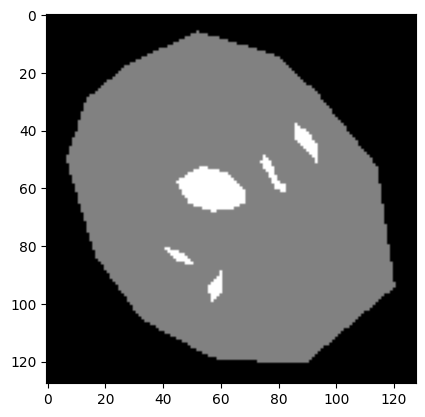

In [141]:
#####################################################################




#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()